# Strongly Convex Optimization with Gradient Descent using Exact Line Search, the Heavy Ball Method and Nesterov Acceleration

This code solves a generalized linear regression problem using different optimization methods and compares their efficiency.

In [1]:
import numpy as np
from numpy.random import default_rng 

In [2]:
#Generating the data
# note by construction we ensure 
# 1. The problem is strongly convex with parameter m
# 2. The problem has lipschitz gradient with parameter L
rng = default_rng(seed=0)

m=0.01
L=1
kappa=L/m
n=10
A = rng.normal(size=(n,n))
[Q,R]=np.linalg.qr(A)
D=rng.random(n)
D=10**D
Dmin=np.min(D)
Dmax=np.max(D)
D=(D-Dmin)/(Dmax-Dmin)
D = m + D*(L-m)
A = Q.T@np.diag(D)@Q
epsilon=1.e-6
eps = epsilon
kmax=1000
x0 = rng.normal(size=n) 

In [3]:
def obj(A,x): # Define the objective function that returns the function value, gradient, and Hessian matrix
    fval = np.dot(x, np.matmul(A,x)) / 2 # fval holds the least-squares function value
    grad = np.matmul( A + np.transpose(A), x) / 2 # grad holds the gradient vector (A + A^T)x
    hess = (A + np.transpose(A)) / 2 # Hessian holds the Hessian matrix A + A^T
    return fval, grad, hess

feval = lambda x: obj(A, x)[0] # Use the lambda operator to define function handles that can pass into algorithms
grad = lambda x: obj(A, x)[1]
hess = lambda x: obj(A, x)[2]

In [4]:
def GD(x, feval, grad, stepsize, eps): 
    '''
    input:
        x:          initial point
        feval:      objective function 
        grad:       gradient of objective function 
        stepsize:   function handle to handle different stepsize schemes such as constant, exact line search, 
                    and Wolfes' cnoditions
        eps         termiination criteria 

    output: 
        x:          final output 
        fv:         final objective avlue
        g:          gradient at final iterate
        history:    history of objective value
        iter_count: number of iteration needed till convergence

    '''
    
    #print("Starting GD \n")
    x = np.copy(x)
    fv = feval(x)
    g = grad(x)
    history = []
    iter_count = 0
    
    while fv > eps: # This cannot be used as a stopping criteria for a general problem as we don't know f^* = 0. 
                    # A more appropriate stopping criteria is using the norm of the gradient
        
        # steepest descent method
        x -= stepsize(x, grad(x)) * grad(x)
        fv = feval(x)
        history.append(fv)
        iter_count += 1
        #print(iter_count, fv)
        
    return x, fv, g, history, iter_count

In [5]:
# compute the optimal step size by exact line search
def exact_line_search(xk, dk, A):
    '''
    input:
        xk  - Current location
        dk  - Search Drection 
        A   - Matrix A

    output: 

    '''
    
    H = A + np.transpose(A)
    numerator = np.dot(dk, np.matmul(H, xk)) # this is x^T (A + A^T) (A^T + A) x
    denominator = np.dot(dk, np.matmul(H, dk))
    
    tau = numerator/denominator
    
    # tau  = (feval(xk) - feval(xk - tau * dk)) / (c1 * np.dot(dk, grad(xk)))
    
    return tau # returns the optimal step size by exact line search

In [6]:
def heavy_ball(x, feval, grad, alpha, beta, eps):
    '''
    input:
        x:           initial point
        feval:       objective function 
        grad:        gradient of objective function 
        tau:         step size toward current gradient
        beta:        momentum correction 
        eps:         termiination criteria 

    output: 
        x:           final output 
        fv:          final objective avlue
        g:           gradient at final iterate
        history:     history of objective value
        iter_count:  number of iteration needed till convergence  
    '''
    
    #print("Starting heavy ball \n")
    x_curr = np.copy(x)
    # x_{k-1}
    x_prev = np.copy(x)
    fv = feval(x_curr)
    g = grad(x_curr)
    history = []
    iter_count = 0

    while fv > eps:
        # heavy_ball method
        x_next = x_curr - alpha * grad(x_curr) + beta * (x_curr - x_prev)
        x_prev = np.copy(x_curr)
        x_curr = np.copy(x_next)
        fv = feval(x_curr)
        history.append(fv)
        iter_count += 1
        
    return x_curr, fv, g, history, iter_count

In [7]:
def Nesterov(x, feval, grad, alpha, beta, eps):
        
    '''
    input:
        x       - initial point
        feval    - objective function 
        grad     - gradient of objective function 
        alpha    - momentum term for location 
        beta     - step size toward corrected gradient
        eps      - termiination criteria 
        
    output: 
        x          - final output 
        fv         - final objective avlue
        g          - gradient at final iterate
        history    - history of objective value
        iter_count - number of iteration needed till convergence  
    '''
    #print("Starting Nesterov \n")
    
    x_prev = np.copy(x)
    x_curr = np.copy(x)
    fv = feval(x_curr)
    history = []
    iter_count = 0
    while fv > eps:
        # nesterov accelerated gradient 
        p = x_curr + beta * (x_curr - x_prev)
        x_prev = np.copy(x_curr)
        x_curr = p - alpha * grad(p)
        
        fv = feval(x_curr)
        history.append(fv)
        
        iter_count += 1


    return x_curr, fv, grad(x_curr), history, iter_count

In [8]:
#x0 = rng.normal(size=n)
#beta = (np.sqrt(L)-np.sqrt(m))/(np.sqrt(L)+np.sqrt(m))
#x, fv, g, history5, iter_count5 = Nesterov(x0, feval, grad, alpha, beta, eps)
#print(iter_count5)

In [9]:
rng = default_rng(seed=0)

T = 10
Num_Iterations = np.zeros((T,5))
eps =1e-6

for t in range(T):
    x0 = rng.normal(size=n)
    stepsize = lambda xk, dk: 2/(m+L)
    x, fv, g, history1, iter_count1 = GD(x0, feval, grad, stepsize, eps)
    Num_Iterations[t,0] = iter_count1
  
    stepsize = lambda xk, dk: 1/L
    x, fv, g, history2, iter_count2 = GD(x0, feval, grad, stepsize, eps)
    Num_Iterations[t,1] = iter_count2
  
    stepsize = lambda xk, dk: exact_line_search(xk, dk, A)
    x, fv, g, history3, iter_count3 = GD(x0, feval, grad, stepsize, eps)
    Num_Iterations[t,2] = iter_count3
  
    alpha = 4/(np.sqrt(L)+np.sqrt(m))**2
    beta = (np.sqrt(L)-np.sqrt(m))/(np.sqrt(L)+np.sqrt(m))
    x, fv, g, history4, iter_count4 = heavy_ball(x0, feval, grad, alpha, beta, eps)
    Num_Iterations[t,3] = iter_count4
  
    alpha = 1/L
    beta = (np.sqrt(L)-np.sqrt(m))/(np.sqrt(L)+np.sqrt(m))
    x, fv, g, history5, iter_count5 = Nesterov(x0, feval, grad, alpha, beta, eps)
    Num_Iterations[t,4] = iter_count5
    
print(Num_Iterations)

[[323. 306. 147.  76.  40.]
 [340. 323. 161.  80.  44.]
 [315. 317. 150.  67.  47.]
 [326. 385. 188.  72.  55.]
 [282. 480. 243.  79.  65.]
 [309. 320. 162.  72.  47.]
 [244. 412. 205.  75.  58.]
 [258. 396. 196.  76.  56.]
 [314. 278. 139.  76.  41.]
 [341. 354. 180.  77.  39.]]


In [10]:
Algs = [r'SD $\alpha = 2/(m+L)$', r'SD $\alpha = 1/L$', r'SD Exact', 'Heavy Ball', 'Nesterov']
print(Algs)
print(np.mean(Num_Iterations, axis = 0))

['SD $\\alpha = 2/(m+L)$', 'SD $\\alpha = 1/L$', 'SD Exact', 'Heavy Ball', 'Nesterov']
[305.2 357.1 177.1  75.   49.2]


In [11]:
stepsize = lambda xk, dk: 2/(m+L)
x, fv, g, history1, iter_count1 = GD(x0, feval, grad, stepsize, eps)

stepsize = lambda xk, dk: 1/L
x, fv, g, history2, iter_count2 = GD(x0, feval, grad, stepsize, eps)

stepsize = lambda xk, dk: exact_line_search(xk, dk, A)
x, fv, g, history3, iter_count3 = GD(x0, feval, grad, stepsize, eps)

alpha = 4/(np.sqrt(L)+np.sqrt(m))**2
beta = (np.sqrt(L)-np.sqrt(m))/(np.sqrt(L)+np.sqrt(m))
x, fv, g, history4, iter_count4 = heavy_ball(x0, feval, grad, alpha, beta, eps)

alpha = 1/L
beta = (np.sqrt(L)-np.sqrt(m))/(np.sqrt(L)+np.sqrt(m))
x, fv, g, history5, iter_count5 = Nesterov(x0, feval, grad, alpha, beta, eps)


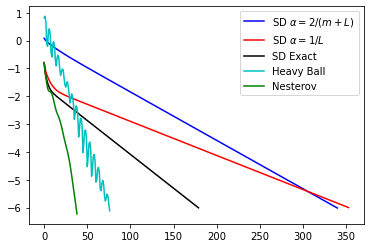

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(np.arange(iter_count1),np.log10(np.array(history1)),'b')
plt.plot(np.arange(iter_count2),np.log10(np.array(history2)),'r')
plt.plot(np.arange(iter_count3),np.log10(np.array(history3)),'k')
plt.plot(np.arange(iter_count4),np.log10(np.array(history4)),'c')
plt.plot(np.arange(iter_count5),np.log10(np.array(history5)),'g')

plt.legend((r'SD $\alpha = 2/(m+L)$', r'SD $\alpha = 1/L$', r'SD Exact', 'Heavy Ball', 'Nesterov'), loc = 'upper right')

We see that gradient descent with Nesterov Acceleration provides the fastest convergence of all the methods.